In [2]:
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
import sys
sys.path.append("../")
import os
from tqdm import tqdm_notebook
import pickle as pkl

from distribution import Pareto, Exp, Normal
from finite import curves_one_stage
from finite import greedy, dp, beta, get_data
from normal_prior import DecisionMaker

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
import matplotlib
matplotlib.style.use('classic')

In [3]:
def get_us(dm, method='newton'):
    a1s = np.arange(0.01, 1, 0.01)
    ts, us, ps = [], [], []
    for a1 in a1s:
        tobl = dm.group_oblivious_threshold(a1)
        tdp = dm.dp_threshold(a1)
        topt = dm.opt1_threshold(a1, method=method)
        tgamma_obl = dm.gamma_threshold(a1)
        tgamma_opt = dm.gamma_opt_threshold(a1, method=method)
        ts.append([tobl, tdp, topt, tgamma_obl, tgamma_opt])
        us.append([dm.utility1(tobl, a1), dm.utility1(tdp, a1), dm.utility1(topt, a1),\
                   dm.utility1(tgamma_obl, a1), dm.utility1(tgamma_opt, a1)])
        ps.append([dm.selection_proba1(tobl), dm.selection_proba1(tdp), dm.selection_proba1(topt),\
            dm.selection_proba1(tgamma_obl), dm.selection_proba1(tgamma_opt)])
    return a1s, np.array(ts).T, np.array(us).T, np.array(ps).T

In [4]:
param = {
    'sigmag': [3, 0.2],
    'a2': 0.1,
    'pg': [0.4, 0.6],
    'prior': Normal(1, 1)
}

Calculate $U$ and $x_A$ for $n=50, 100, 200$

In [7]:
n=100
T=10000
pot = st.norm(1,1)

a1s = np.arange(0.1, 1.01, 0.01)

res = {'gr': [], 'dp': [], 'opt': []}
for t in tqdm_notebook(range(T)):
    data = get_data(n, param, potential=pot)
    res['gr'].append(curves_one_stage(data, a1s, T=T, alg=greedy))
    res['dp'].append(curves_one_stage(data, a1s, T=T, alg=dp))
    q, x, g =  data
    xtilde = []
    for i in range(len(x)):
        rho = 1 / (1 + param['sigmag'][1-g[i]]**2)
        xtilde.append(rho * x[i] + (1-rho))
    
    res['opt'].append(curves_one_stage((q, np.array(xtilde), g), a1s, T=T, alg=greedy))

res['gr'] = np.array(res['gr'])
res['dp'] = np.array(res['dp'])
res['opt'] = np.array(res['opt'])
with open("./data/finite/normal-{}-{}.pkl".format(n, T), 'wb') as f:
    pkl.dump(res, f)

Calculate $U$ and $x_A$ for $n=\infty$

In [8]:
dm = DecisionMaker(mu=[1, 1], sigma=[1, 1], sigmag=[3, 0.2], beta=[0, 0], pg=[0.4, 0.6])
a1s, ts, us, ps = get_us(dm, method='bisect')

Plot $U$ and CI for all algorithms

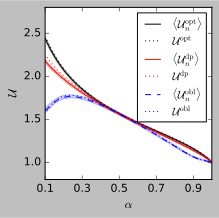

In [19]:
n=100
T=10000

plt.figure(figsize=(3,3))
lw=1
m = 10

with open("./data/finite/normal-{}-{}.pkl".format(n, T), 'rb') as f:
    res = pkl.load(f)

plt.plot(np.array(res['opt'][0,0,:]), np.array(res['opt'][:,1,:]).mean(axis=0), \
         ls='-', color='k', lw=lw, label="$\\langle\mathcal{U}_n^\mathrm{opt}\\rangle$")
plt.fill_between(np.array(res['opt'][0,0,:]), np.array(res['opt'][:,1,:]).mean(axis=0) - np.array(res['opt'][:,1,:]).std(axis=0)/np.sqrt(n),\
np.array(res['opt'][:,1,:]).mean(axis=0) + np.array(res['opt'][:,1,:]).std(axis=0)/np.sqrt(n),\
                 alpha=0.2,color='k')
plt.plot(a1s[m:], us[2][m:],  'k:', label='$\mathcal{U}^\mathrm{opt}$')


plt.plot(np.array(res['dp'][0,0,:]), np.array(res['dp'][:,1,:]).mean(axis=0), \
         ls='-', color='r', lw=lw, label="$\\langle\mathcal{U}_n^\mathrm{dp}\\rangle$")
plt.fill_between(np.array(res['dp'][0,0,:]), np.array(res['dp'][:,1,:]).mean(axis=0) - np.array(res['dp'][:,1,:]).std(axis=0)/np.sqrt(n),\
np.array(res['dp'][:,1,:]).mean(axis=0) + np.array(res['dp'][:,1,:]).std(axis=0)/np.sqrt(n),\
                 alpha=0.2,color='r')

plt.plot(a1s[m:], us[1][m:],  'r:', label='$\mathcal{U}^\mathrm{dp}$')

plt.plot(np.array(res['gr'][0,0,:]), np.array(res['gr'][:,1,:]).mean(axis=0), \
         ls='--', color='b', lw=lw, label="$\\langle\mathcal{U}_n^\mathrm{obl}\\rangle$")
plt.fill_between(np.array(res['gr'][0,0,:]), np.array(res['gr'][:,1,:]).mean(axis=0) - np.array(res['dp'][:,1,:]).std(axis=0)/np.sqrt(n),\
np.array(res['gr'][:,1,:]).mean(axis=0) + np.array(res['gr'][:,1,:]).std(axis=0)/np.sqrt(n),\
                 alpha=0.2, color='b')

plt.plot(a1s[m:], us[0][m:],  'b:', label='$\mathcal{U}^\mathrm{obl}$')

plt.xticks([0.1, 0.3, 0.5, 0.7,0.9], fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("$\\alpha$", fontsize=12)
plt.ylabel("$\mathcal{U}$", rotation=90, fontsize=12)
plt.ylim(0.8, 2.8)

plt.legend(loc='best', fontsize=11)
plt.savefig("../fig/u-normal-n=100.pdf", bbox_inches='tight')

Plot $U_{dp} / U_{obl}$ for all algorithms

50
100



(array([0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

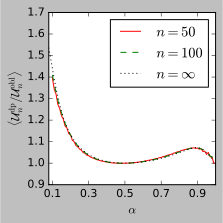

In [15]:
plt.figure(figsize=(3,3))
T=10000
color=['r', 'g', 'b', 'k']
ls=['-','--', '-.', ':']


for i, n in enumerate(tqdm_notebook([50, 100])):

    with open("./data/finite/normal-{}-{}.pkl".format(n, T), 'rb') as f:
        res = pkl.load(f)
    print (n)
    plt.plot(np.array(res['gr'][0,0,:]), \
             ((np.array(res['dp'][:,1,:])/np.array(res['gr'][:,1,:]))).mean(axis=0),\
             label="$n={}$".format(n), color=color[i], ls=ls[i])
    
plt.ylabel("$\\langle \mathcal{U}_n^\mathrm{dp}/\mathcal{U}_n^\mathrm{obl}\\rangle$", rotation=90,\
           fontsize=12)
plt.plot(a1s, us[1] / us[0],  'k:', label='$n=\\infty$')

plt.legend()
plt.xlabel("$\\alpha$", fontsize=12)
plt.xlim(0.08, 1)
plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9],fontsize=11)
plt.yticks(fontsize=11)
# plt.savefig("../fig/finite-mean-of-ratio-dp-obl.pdf", bbox_inches='tight')

Plot $U_{opt} / U_{dp}$ for all algorithms

50
100



(array([0.95, 1.  , 1.05, 1.1 , 1.15, 1.2 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

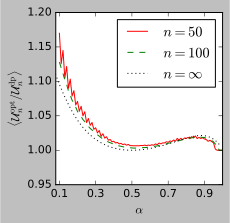

In [16]:
plt.figure(figsize=(3,3))
T=10000
color=['r', 'g', 'b', 'k']
ls=['-','--', '-.', ':']


for i, n in enumerate(tqdm_notebook([50, 100])):

    with open("./data/finite/normal-{}-{}.pkl".format(n, T), 'rb') as f:
        res = pkl.load(f)
    print (n)
    plt.plot(np.array(res['gr'][0,0,:]), \
             ((np.array(res['opt'][:,1,:])/np.array(res['dp'][:,1,:]))).mean(axis=0),\
             label="$n={}$".format(n), color=color[i], ls=ls[i])
plt.ylabel("$\\langle \mathcal{U}_n^\mathrm{opt}/\mathcal{U}_n^\mathrm{dp}\\rangle$", rotation=90,\
           fontsize=12)
plt.plot(a1s, us[2] / us[1],  'k:', label='$n=\\infty$')

plt.legend(loc='upper right')
plt.xlabel("$\\alpha$", fontsize=12)
plt.xlim(0.08, 1)
plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9],fontsize=11)
plt.yticks(fontsize=11)
# plt.savefig("../fig/finite-mean-of-ratio-opt-dp.pdf", bbox_inches='tight')